In [59]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

## Load the 3 data sets from Word Data Bank
***
### Country dataframe

In [60]:
country = pd.DataFrame.from_csv('data/Country.csv', index_col = None)
country.head(2)

,CountryCode,ShortName,TableName,LongName,Alpha2Code,CurrencyUnit,SpecialNotes,Region,IncomeGroup,Wb2Code,...,GovernmentAccountingConcept,ImfDataDisseminationStandard,LatestPopulationCensus,LatestHouseholdSurvey,SourceOfMostRecentIncomeAndExpenditureData,VitalRegistrationComplete,LatestAgriculturalCensus,LatestIndustrialData,LatestTradeData,LatestWaterWithdrawalData
0,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,Consolidated central government,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2013.0,2000.0
1,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,...,Budgetary central government,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2011.0,2013.0,2006.0


In [61]:
country.shape

(247, 31)

The Country data frame has 31 descriptor columns for each of the 247 rows (countries of groups of countries). Let's get a sense for how many individual countries exist and how many aggregate groupings (e.g. world, regions, income groupings). 

In [62]:
# ID aggregated rows by searching for 'aggregate' in the special notes column 
text = country.SpecialNotes.fillna('0')
len(text[text.str.contains('aggregate')])

33

### Load 'Series' dataframe (renamed as metrics)

In [63]:
metrics = pd.DataFrame.from_csv('data/Series.csv', index_col = None)

One row per series/metric, columns provide defintions, units, periodicity sources, etc. Now let's get a better sense for the key categories (and sub-categories) of development indicators.

Interested in health/life expactancy as the target indicators. SP.DYN.LE00.IN is a good fit: Life expectancy at birth, total (years)

In [64]:
metrics[metrics.IndicatorName.str.contains('Life expectancy')].head()

,SeriesCode,Topic,IndicatorName,ShortDefinition,LongDefinition,UnitOfMeasure,Periodicity,BasePeriod,OtherNotes,AggregationMethod,LimitationsAndExceptions,NotesFromOriginalSource,GeneralComments,Source,StatisticalConceptAndMethodology,DevelopmentRelevance,RelatedSourceLinks,OtherWebLinks,RelatedIndicators,LicenseType
818,SP.DYN.LE00.FE.IN,Health: Mortality,"Life expectancy at birth, female (years)",Life expectancy at birth indicates the average...,Life expectancy at birth indicates the number ...,NaN,Annual,NaN,NaN,Weighted average,Complete vital registration systems are not co...,NaN,NaN,(1) United Nations Population Division. World ...,Life expectancy at birth used here is the aver...,Mortality rates for different age groups (infa...,NaN,NaN,NaN,Open
819,SP.DYN.LE00.MA.IN,Health: Mortality,"Life expectancy at birth, male (years)",Life expectancy at birth indicates the average...,Life expectancy at birth indicates the number ...,NaN,Annual,NaN,NaN,Weighted average,Complete vital registration systems are not co...,NaN,NaN,(1) United Nations Population Division. World ...,Life expectancy at birth used here is the aver...,Mortality rates for different age groups (infa...,NaN,NaN,NaN,Open
820,SP.DYN.LE00.IN,Health: Mortality,"Life expectancy at birth, total (years)",Life expectancy at birth indicates the average...,Life expectancy at birth indicates the number ...,NaN,Annual,NaN,NaN,Weighted average,Complete vital registration systems are not co...,NaN,NaN,Derived from male and female life expectancy a...,Life expectancy at birth used here is the aver...,Mortality rates for different age groups (infa...,NaN,NaN,NaN,Open


Briefly view all the indicator categories that are available as predictors of Life Expectancy

In [65]:
# Highlevel topic categories
splitTopics = metrics.Topic.str.partition(':')
splitTopics.groupby([0,2]).size()

0                          2                                                                          
Economic Policy & Debt      Balance of payments: Capital & financial account                              11
                            Balance of payments: Current account: Balances                                 4
                            Balance of payments: Current account: Goods, services & income                22
                            Balance of payments: Current account: Transfers                                7
                            Balance of payments: Reserves & other items                                    6
                            External debt: Amortization                                                   18
                            External debt: Arrears, reschedulings, etc.                                   22
                            External debt: Commitments                                                     5
                         

### Load 'Indicators' dataframe (renamed as 'df')
***

In [66]:
df = pd.DataFrame.from_csv('data/indicators.csv', index_col=None)

#check availability of data and how missing values are handled (confirm unavailable data reported as'NaN')
df[df.IndicatorName.str.contains('GDP per capita')].groupby(['CountryName', 'IndicatorName']).size().unstack()

IndicatorName,GDP per capita (constant 2005 US$),GDP per capita (constant LCU),GDP per capita (current LCU),GDP per capita (current US$),GDP per capita growth (annual %),"GDP per capita, PPP (constant 2011 international $)","GDP per capita, PPP (current international $)",Government expenditure per primary student as % of GDP per capita (%),Government expenditure per secondary student as % of GDP per capita (%),Government expenditure per tertiary student as % of GDP per capita (%)
CountryName,,,,,,,,,,
Afghanistan,13.0,13.0,36.0,36.0,12.0,13.0,13.0,NaN,NaN,NaN
Albania,35.0,35.0,35.0,31.0,34.0,25.0,25.0,NaN,NaN,NaN
Algeria,55.0,55.0,55.0,55.0,54.0,25.0,25.0,4.0,4.0,NaN
American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
Andorra,44.0,44.0,44.0,44.0,43.0,NaN,NaN,9.0,9.0,5.0
Angola,1.0,18.0,29.0,29.0,17.0,1.0,1.0,NaN,NaN,2.0
Antigua and Barbuda,38.0,38.0,38.0,38.0,37.0,25.0,25.0,1.0,2.0,1.0
Arab World,40.0,NaN,NaN,47.0,39.0,25.0,25.0,NaN,NaN,NaN
Argentina,55.0,55.0,55.0,53.0,54.0,NaN,NaN,15.0,15.0,15.0


## Data wrangling & inferential statistics
*** 

### Plot life expectancy trends for World Bank's country income groupings (high, med & low)

In [67]:
income = country[['CountryCode','IncomeGroup', 'SpecialNotes']]
df_Le = df.merge(income, left_on=df.CountryCode, right_on = income.CountryCode, how='outer')
df_Le = df_Le[(df_Le.IndicatorName =='Life expectancy at birth, total (years)') 
                              & (df_Le.SpecialNotes.str.contains('aggregate'))]

df_Le = pd.pivot_table(df_Le, values = 'Value', index='Year', columns='CountryName')

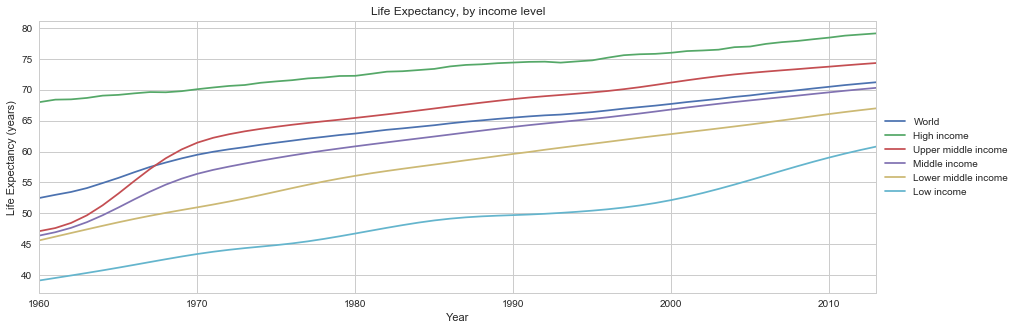

In [68]:
income_grps = ['World', 'High income', 'Upper middle income', 'Middle income','Lower middle income', 'Low income']

df_Le[income_grps].plot(figsize=(15,5))
plt.title('Life Expectancy, by income level')
plt.ylabel('Life Expectancy (years)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

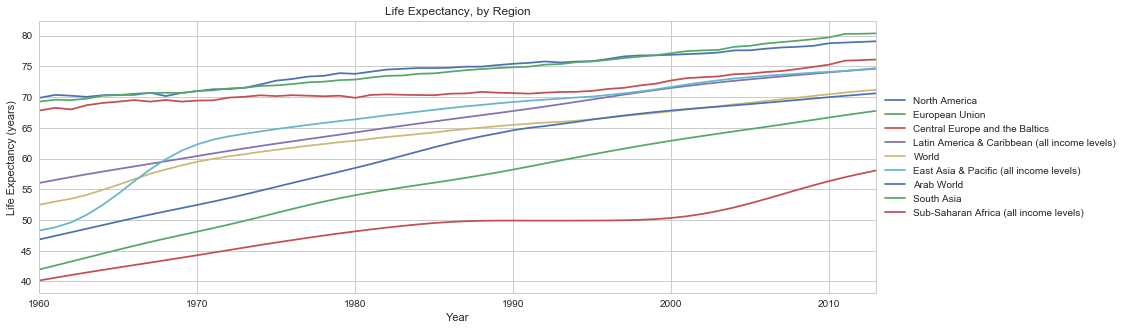

In [69]:
regions = ['North America','European Union','Central Europe and the Baltics', 
        'Latin America & Caribbean (all income levels)','World',
        'East Asia & Pacific (all income levels)','Arab World',  
        'South Asia', 'Sub-Saharan Africa (all income levels)']

df_Le[regions].plot(figsize=(15,5))
plt.title('Life Expectancy, by Region')
plt.ylabel('Life Expectancy (years)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

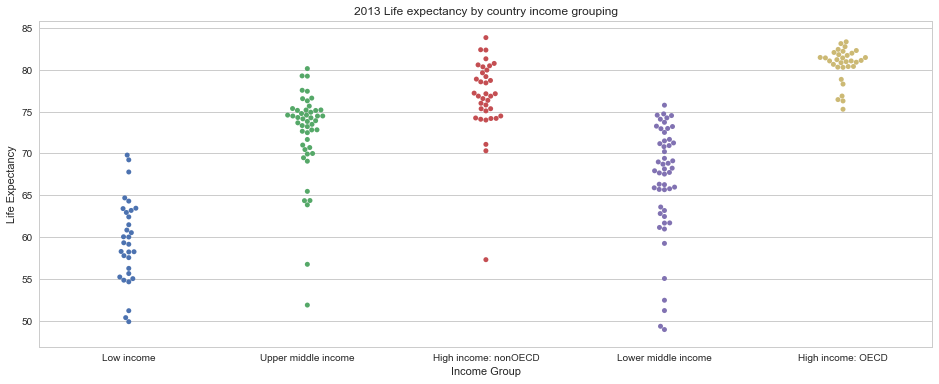

In [70]:
# Plot 2013 life expectancy for all countries, by income grouping
df_2013 = df.merge(income, left_on=df.CountryCode, right_on = income.CountryCode, how='outer')

df_2013 = df_2013[(df_2013.IndicatorName =='Life expectancy at birth, total (years)') & (df_2013.Year == 2013)]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))
_ = sns.swarmplot(x='IncomeGroup', y = 'Value', data = df_2013)
_ = plt.xlabel('Income Group')
_ = plt.ylabel('Life Expectancy')
_ = plt.title('2013 Life expectancy by country income grouping')

plt.show()

In [71]:
df_2013.groupby(['IncomeGroup']).describe().unstack()[['Value']].round(1)

Value                                         
                     count  mean  std   min   25%   50%   75%   max
IncomeGroup                                                        
High income: OECD     32.0  80.6  2.0  75.3  80.4  81.1  81.8  83.3
High income: nonOECD  36.0  76.8  4.6  57.3  74.9  77.0  79.7  83.8
Low income            31.0  59.5  5.0  49.9  55.9  59.3  63.1  69.8
Lower middle income   51.0  66.9  6.7  48.9  63.4  68.1  71.6  75.8
Upper middle income   48.0  72.5  5.3  51.9  70.9  74.0  75.1  80.1

## Machine learning: Predicting life expectancy with linear regression
*************
First, let's set up the dataframe with the top ~20 features that could be used to predict life expectancy. These features were selected to present a well-populated and diverse representation of the available development indicators. 

#### Setting up the dataframe, and EDA on the data subset 

In [72]:
columns = {
            "SP.DYN.LE00.IN": "LifeExpectancy",
            "SH.XPD.PCAP": "HealthSpend",
            'SP.ADO.TFRT': 'Adolescent_fertility',
            'NY.GDP.PCAP.CD': 'GDP',
            'SH.STA.ACSN': 'Sanitation',
            'SP.RUR.TOTL.ZS': 'Rural_pop%',
            "NY.ADJ.AEDU.GN.ZS": "EduExp_percentGNI",
            'NY.ADJ.NNTY.KD.ZG': 'National_income_%growth',
            'AG.LND.AGRI.ZS': 'Agricultural_land_%',
            'AG.LND.ARBL.ZS': 'Arable_land_%',
            'MS.MIL.TOTL.TF.ZS': 'Armed_forces_%',
            'SL.EMP.1524.SP.ZS': 'Employment_ratio_15',
            'SE.PRM.ENRR': 'Primary_edu',
            'SE.PRM.ENRL': 'Secondary_edu',
            'SH.XPD.TOTL.ZS': 'Health_exp_%',
            'NE.IMP.GNFS.ZS': 'Imports_%GDP',
            'NV.IND.TOTL.ZS': 'Industry_%GDP',
            'IT.CEL.SETS.P2': 'Mobile_phones_per100',
            'EN.POP.DNST': 'Population_density',
            'SM.POP.REFG': 'Refugee_population',
            'NE.TRD.GNFS.ZS': 'Trade_%GDP',
            'SL.UEM.TOTL.ZS': 'Unemployment_%'
#             'SH.MMR.RISK': 'Maternal_death_perc',
#             'SP.DYN.IMRT.IN': 'Mortality_infant _per1000',
#             'SH.DYN.NMRT': 'Mortality_neonatal_1000',
#             'SH.DYN.MORT': 'Mortality_sub5_1000'
          }

df.IndicatorCode = df.IndicatorCode.astype(str)
df.IndicatorName = df.IndicatorName.astype(str)

# Reshape the data so features are column headers, and countries are rows
pivot = df[df.Year==2013].pivot_table('Value','CountryName', 'IndicatorCode')

features = list(columns.keys())
df_features = pivot[features]
df_features.columns = df_features.columns.to_series()
flattened = pd.DataFrame(df_features.to_records())

df_ml = flattened.rename(index=str, columns=columns)

# Drop countries who do not have a life expectancy value 
df_ml = df_ml[pd.notnull(df_ml.LifeExpectancy)]
df_ml = df_ml.dropna(axis =0, how='any').drop('CountryName', axis = 1)

y = df_ml.LifeExpectancy.values.reshape(-1,1)
X = df_ml.drop(['LifeExpectancy'], axis = 1)

#View summary metrics of the features
X.describe().round(1)

,HealthSpend,Adolescent_fertility,GDP,Sanitation,Rural_pop%,EduExp_percentGNI,National_income_%growth,Agricultural_land_%,Arable_land_%,Armed_forces_%,...,Primary_edu,Secondary_edu,Health_exp_%,Imports_%GDP,Industry_%GDP,Mobile_phones_per100,Population_density,Refugee_population,Trade_%GDP,Unemployment_%
count,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,...,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0
mean,1472.5,48.0,15479.1,72.2,42.0,4.4,3.6,45.7,18.7,0.9,...,106.2,46223916.3,7.6,45.4,28.4,104.6,106.4,939019.8,84.9,7.9
std,2236.8,40.8,19601.2,29.0,21.0,1.5,4.1,18.3,14.4,0.7,...,11.4,118972155.6,2.7,19.5,7.7,33.1,113.4,2711956.1,36.1,5.4
min,19.6,1.7,239.9,10.5,2.2,1.3,-3.5,2.7,0.4,0.1,...,72.2,52573.0,2.8,16.5,14.9,25.0,1.8,9.0,30.0,0.3
25%,97.8,15.6,1754.6,50.2,24.4,3.2,0.6,35.2,8.5,0.5,...,99.9,723320.2,5.7,30.8,22.9,85.9,33.6,1331.5,58.8,5.1
50%,447.0,34.9,7077.3,83.1,39.8,4.5,3.5,44.2,12.5,0.8,...,104.4,3017017.0,6.9,39.2,27.5,108.6,72.6,39996.5,72.9,6.8
75%,1388.8,69.6,20265.1,97.7,57.7,5.1,5.6,57.3,27.1,1.1,...,108.9,18861731.5,9.4,60.2,33.2,124.9,126.0,392464.5,108.3,9.2
max,9714.8,206.0,102832.3,100.0,88.5,9.8,16.5,80.6,56.7,4.9,...,145.2,713571904.0,17.1,101.2,60.0,184.7,515.3,15727390.0,183.4,31.1


Visualize the correlation between all features by using the a heat maps and Pearson's correlation  

In [73]:
df_ml.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

Fit a linear regression model with all features, and view the coefficients.

In [74]:
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
lr.score(X, y)

pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lr.coef_[0,:]})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,HealthSpend,-8.764092e-04
1,Adolescent_fertility,-1.644478e-02
2,GDP,1.436123e-04
3,Sanitation,1.548599e-01
4,Rural_pop%,-1.010184e-01
5,EduExp_percentGNI,-6.068114e-01
6,National_income_%growth,-6.205710e-02
7,Agricultural_land_%,-3.155886e-02
8,Arable_land_%,-3.915116e-02
9,Armed_forces_%,1.782669e-01


In [75]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
model_ols = ols('y ~ X', df_ml).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     30.78
Date:                Sun, 03 Dec 2017   Prob (F-statistic):           2.40e-28
Time:                        11:39:06   Log-Likelihood:                -227.84
No. Observations:                  96   AIC:                             499.7
Df Residuals:                      74   BIC:                             556.1
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     70.4854      6.609     10.665      0.000        57.317    83.654
X[0]          -0.0009      0.001     -1.202      0.233        -0.002     0.001
X[1]          -0.0164      0.019     -0.871      0.387        -0.054     0.021
X[2]           0.0001   7.72e-05      1.859      0.067     -1.03e-05     0.000
X[3]           0.1549      0.026      6.010      0.000         0.104     0.206
X[4]          -0.1010      0.030     -3.362      0.001        -0.161    -0.041
X[5]          -0.6068      0.264     -2.301      0.024        -1.132    -0.081
X[6]          -0.0621      0.103     -0.605      0.547        -0.266     0.142
X[7]          -0.0316      0.024     -1.332      0.187        -0.079     0.016
X[8]          -0.0392      0.035     -1.132      0.261        -0.108     0.030
X[9]           0.1783      0.586      0.304      0.762        -0.989     1.346
X[10]         -0.0173      0.042     -0.414      0.680        -0.100     0.066
X[11]          0.0293      0.034      0.864      0.390        -0.038     0.097
X[12]       1.143e-08   1.15e-08      0.992      0.324     -1.15e-08  3.44e-08
X[13]          0.2092      0.241      0.867      0.389        -0.272     0.690
X[14]         -0.0131      0.082     -0.160      0.873        -0.176     0.150
X[15]         -0.1093      0.066     -1.648      0.103        -0.241     0.023
X[16]         -0.0087      0.017     -0.521      0.604        -0.042     0.025
X[17]          0.0005      0.004      0.141      0.888        -0.007     0.008
X[18]       -4.56e-07   4.77e-07     -0.956      0.342     -1.41e-06  4.95e-07
X[19]          0.0151      0.044      0.345      0.731        -0.072     0.102
X[20]         -0.2584      0.086     -3.000      0.004        -0.430    -0.087
==============================================================================
Omnibus:                        2.713   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.258   Jarque-Bera (JB):                2.456
Skew:                          -0.096   Prob(JB):                        0.293
Kurtosis:                       3.759   Cond. No.                     2.78e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Fit a regression based on top features (selected based on high correlation & low P)

In [118]:
X_top = df_ml.loc[:,('Sanitation', 'Rural_pop%')]
# X_top = df_ml.loc[:,('Sanitation', 'Rural_pop%', 'HealthSpend')]

X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size = 0.3, random_state=42) 
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

import numpy as np 
cv_results = cross_val_score(lr, X_top, y, cv = 5)
print('Model accuracy with 5 cross validation folds: {}' .format(np.mean(cv_results)))

Model accuracy with 5 cross validation folds: 0.8040573833835737


In [119]:
# The coefficients
pd.DataFrame({'features': X_top.columns, 'estimatedCoefficients': lr.coef_[0,:]})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,Sanitation,0.183838
1,Rural_pop%,-0.117126


In [111]:
lr.intercept_

array([ 62.8683215])

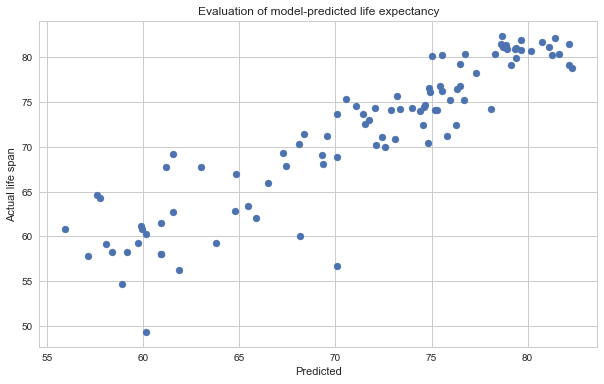

In [99]:
# scatter plot between actual and predicted life expectancy
y_predicted = lr.predict(X_top)
plt.figure(figsize=(10,6))
plt.scatter(y_predicted, y)
plt.xlabel("Predicted")
plt.ylabel("Actual life span")
plt.title('Evaluation of model-predicted life expectancy')

If we look just at Sanitation (below), we see that the Regression coefficient is 0.2485, meaning on average each 0.25% increase in the percent of the population with access to modern sanitation facilities, is associated with a one-year increase in life expectancy.

In [120]:
X_sani = df_ml.loc[:,('Sanitation')].values.reshape(-1,1)
X_top = df_ml.loc[:,('Sanitation', 'Rural_pop%')]

X_train, X_test, y_train, y_test = train_test_split(X_sani, y, test_size = 0.3, random_state=42) 
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_test, y_test)
 
cv_results = cross_val_score(lr, X_sani, y, cv = 5)
print('Model accuracy with 10 cross validation folds: {}' .format(np.mean(cv_results)))

Model accuracy with 10 cross validation folds: 0.770179159601213


In [123]:
lr.coef_

array([[ 0.24664406]])

# Access to sanitation is the biggest drive for life expectancy
Let's dig into the age groups most affected by poor sanitation. We have Mortality rates for neonatals, infants and children under 5, as well as the maternal death rate. Repeating the steps above, we'll create a sub-set of the dataframe with the relevant columns, then run a correlation across this sub-set. 

In [53]:
# Create a sub-set of columns 
columns_san = {
            'SH.STA.ACSN': 'Sanitation_perc_access',
            "SP.DYN.LE00.IN": "LifeExpect_total",
            'SH.MMR.RISK': 'Maternal_death_perc',
            'SP.DYN.IMRT.IN': 'Mortality_infant _per1000',
            'SH.DYN.NMRT': 'Mortality_neonatal_1000',
            'SH.DYN.MORT': 'Mortality_sub5_1000',
          }

df.IndicatorCode = df.IndicatorCode.astype(str)
df.IndicatorName = df.IndicatorName.astype(str)

# piovt the 2013 data so the features are column headers
pivot_san = df[df.Year==2013].pivot_table('Value','CountryName', 'IndicatorCode')

features = list(columns_san.keys())
df_features = pivot[features]
df_features.columns = df_features.columns.to_series()
flattened = pd.DataFrame(df_features.to_records())

df_ml = flattened.rename(index=str, columns=columns_san)

# Drop countries who do not have a life expectancy value 
df_ml = df_ml[pd.notnull(df_ml.LifeExpect_total)]
df_ml = df_ml.dropna(axis =0, how='any').drop('CountryName', axis = 1)

In [54]:
df_ml.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)